# Hydra Multi-Asset Verification Test

## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.



In order to better mimic the behavior of Uniswap, we need to pay special attention to two things:
1. make explicit that we want numbers to be treated as integers by the Python interpreter - there are probably more casts to `int` than needed throughout the code;
1. Uniswap was coded in Vyper, where the `/` operator applied to integer variables returns the dividend of the division. In order to achieve the same in Python, we need to use _"floor division"_ (`//`) instead of _"true division"_ (`/`).

In [1]:
expr = '10000000000000000000 / 5000000000000000001'
print(f'{expr} = {eval(expr)}')
expr = 'int(10000000000000000000 / 5000000000000000001)'
print(f'{expr} = {eval(expr)}')
expr = '10000000000000000000 // 5000000000000000001'
print(f'{expr} = {eval(expr)}')

10000000000000000000 / 5000000000000000001 = 2.0
int(10000000000000000000 / 5000000000000000001) = 2
10000000000000000000 // 5000000000000000001 = 1


## Model File structure
* Uniswap_Model.ipynb
* model

In the model folder there exist 4 files and a parts folder, the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), and [state_variables.py](state_variables.py). The [config.py](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [partial_state_update_block.py](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [state_variables.py](state_variables.py) defines the state variables and [run.py](model/run.py) actually runs the simulation. 

The components of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)
* uniswap_events.pickle* 

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in the [utils.py](model/parts/utils.py).


### Model dataset*


## Run Model

In [2]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

df = run.run()
rdf = run.postprocessing(df)
# rdf = df # debugging substeps



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 5, 1, 15)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 11.36s


## Analysis

For information on how to access and analysis data from the Eth/Dai Uniswap smart contract, visit our sister notebook [here](Uniswap_EthDai_Exchange_Data.ipynb).




In [3]:
rdf.Q

5      399998.01
10     399996.01
15     399994.02
20     399992.02
25     399990.03
          ...   
4980   398028.67
4985   398026.71
4990   398024.75
4995   398022.78
5000   398020.82
Name: Q, Length: 1000, dtype: float64

In [4]:
model_history = rdf[['UNI_Qi', 'UNI_Ri', 'UNI_Si']]
model_history.columns = ['model_UNI_Qi', 'model_UNI_Ri', 'model_UNI_Si']

uniswap_j = rdf[['UNI_Qj', 'UNI_Rj', 'UNI_Sj']]
uniswap_j.columns = ['UNI_Qj', 'UNI_Rj', 'UNI_Sj']

hydra = rdf[['Q', 'H', 'Sq']]
hydra.columns = ['Hydra_Q', 'Hydra_H', 'Hydra_Sq']

In [5]:
# for t in range(20):
#     print(rdf['asset'][t])

Despite the simplifications, the outputs of the model are very similar to the real data

In [6]:
rdf.head(10)

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,uni_agents,UNI_P_RQi,UNI_P_RQj,pool,Q,H,Wq,Sq,hydra_agents,simulation,subset,run,substep,timestep
5,199999,1000010,200000000000,199997,1000020,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399998.01,399998.01,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,1
10,199998,1000020,200000000000,199994,1000040,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399996.01,399996.01,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,2
15,199997,1000030,200000000000,199991,1000060,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399994.02,399994.02,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,3
20,199996,1000040,200000000000,199988,1000080,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399992.02,399992.02,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,4
25,199995,1000050,200000000000,199985,1000100,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399990.03,399990.03,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,5
30,199994,1000060,200000000000,199982,1000120,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399988.04,399988.04,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,6
35,199993,1000070,200000000000,199979,1000140,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399986.04,399986.04,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,7
40,199992,1000080,200000000000,199976,1000160,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399984.05,399984.05,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,8
45,199991,1000090,200000000000,199973,1000180,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399982.06,399982.06,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,9
50,199990,1000100,200000000000,199970,1000200,200000000000,m r_i_out r_i_in h q_i ...,4.96,4.96,<class 'model.parts.asset_utils.Asset'>: {'poo...,399980.06,399980.06,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,10


In [7]:
rdf.tail()

,UNI_Qi,UNI_Ri,UNI_Si,UNI_Qj,UNI_Rj,UNI_Sj,uni_agents,UNI_P_RQi,UNI_P_RQj,pool,Q,H,Wq,Sq,hydra_agents,simulation,subset,run,substep,timestep
4980,199004,1009960,200000000000,197012,1019920,200000000000,m r_i_out r_i_in h q_i ...,5.03,5.13,<class 'model.parts.asset_utils.Asset'>: {'poo...,398028.67,398028.67,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,996
4985,199003,1009970,200000000000,197009,1019940,200000000000,m r_i_out r_i_in h q_i ...,5.03,5.13,<class 'model.parts.asset_utils.Asset'>: {'poo...,398026.71,398026.71,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,997
4990,199002,1009980,200000000000,197006,1019960,200000000000,m r_i_out r_i_in h q_i ...,5.03,5.13,<class 'model.parts.asset_utils.Asset'>: {'poo...,398024.75,398024.75,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,998
4995,199001,1009990,200000000000,197003,1019980,200000000000,m r_i_out r_i_in h q_i ...,5.03,5.13,<class 'model.parts.asset_utils.Asset'>: {'poo...,398022.78,398022.78,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,999
5000,199000,1010000,200000000000,197000,1020000,200000000000,m r_i_out r_i_in h q_i ...,5.03,5.14,<class 'model.parts.asset_utils.Asset'>: {'poo...,398020.82,398020.82,400000000000,400000000000,m r_i_out r_i_in h q_i ...,0,0,1,5,1000


<AxesSubplot:>

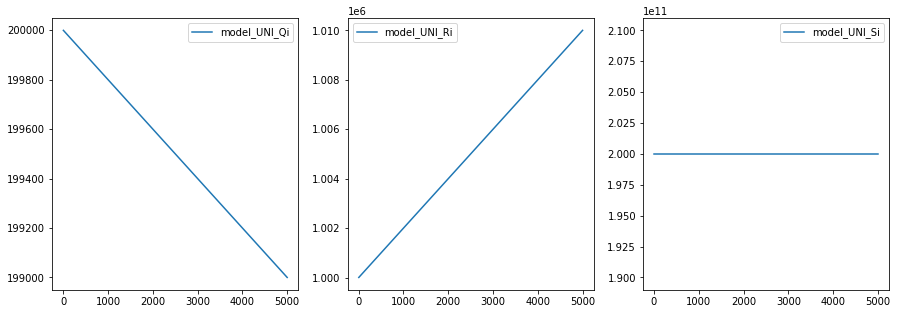

In [8]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Qi'])

ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Ri'])

ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_Si'])


<AxesSubplot:>

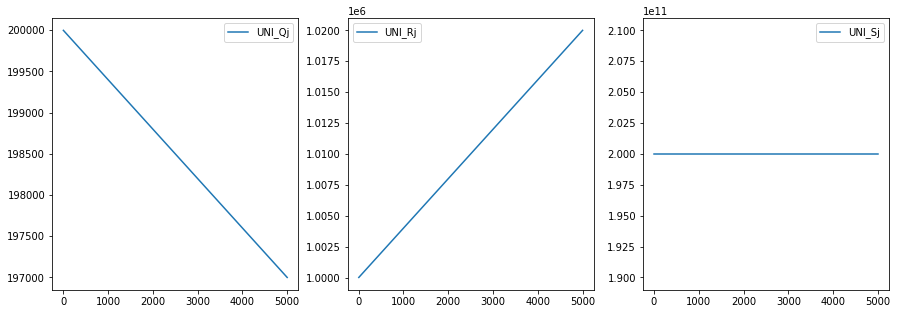

In [9]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Qj'])
ax = plt.subplot(132)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Rj'])
ax = plt.subplot(133)
uniswap_j.astype(float).plot(ax=ax, y=['UNI_Sj'])

<AxesSubplot:>

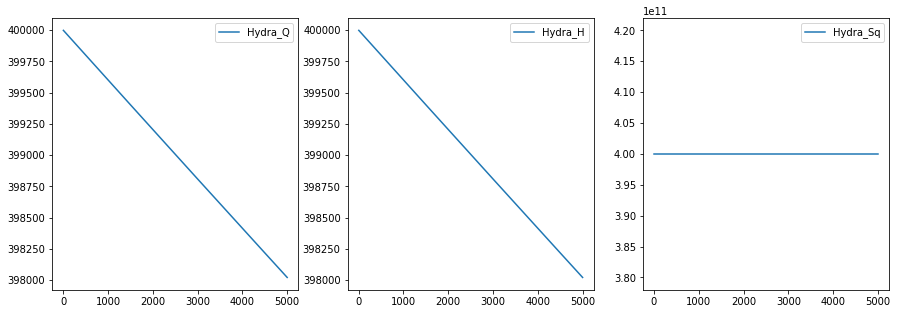

In [10]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
hydra.astype(float).plot(ax=ax, y=['Hydra_Q'])

ax = plt.subplot(132) 
hydra.astype(float).plot(ax=ax, y=['Hydra_H'])

ax = plt.subplot(133)
hydra.astype(float).plot(ax=ax, y=['Hydra_Sq'])

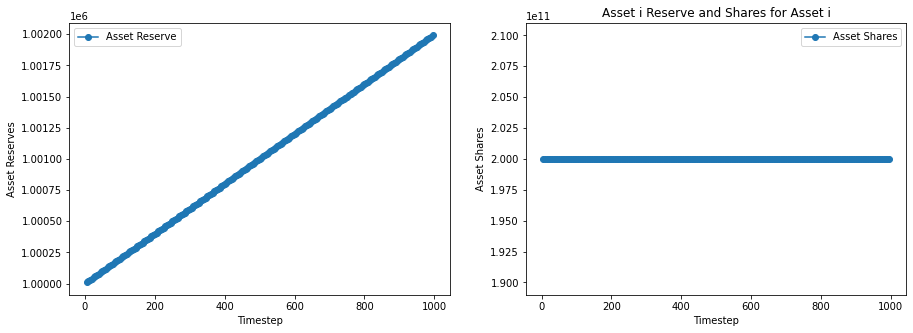

In [11]:
hydra_pool_plot(rdf,'Asset i Reserve and Shares', len(rdf['timestep']),'i')

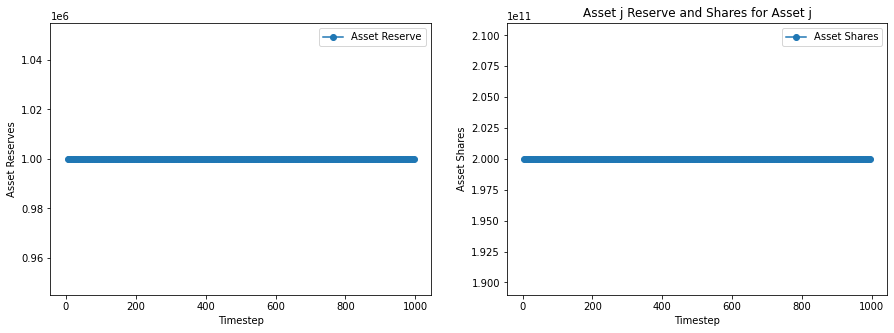

In [12]:
hydra_pool_plot(rdf,'Asset j Reserve and Shares', len(rdf['timestep']),'j')

Only if we look much more closely can we see some deviation

In [13]:
rdf['hydra_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,99980.00,0.00,100002.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,0.00,0.00,0.00,1000000000.00
4,4.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
5,5.00,0.00,0.00,100003.00,0.00,0.00,0.00,99980.00,0.00,0.00,0.00
6,6.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
7,7.00,0.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [14]:
rdf['uni_agents'][rdf.first_valid_index()]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,99980.00,0.00,100002.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,0.00,0.00,0.00,1000000000.00
4,4.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
5,5.00,0.00,0.00,100003.00,0.00,0.00,0.00,99980.00,0.00,0.00,0.00
6,6.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
7,7.00,0.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [15]:
rdf['uni_agents'][rdf.first_valid_index()*10]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,99800.00,0.00,100029.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,0.00,0.00,0.00,1000000000.00
4,4.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
5,5.00,0.00,0.00,100030.00,0.00,0.00,0.00,99800.00,0.00,0.00,0.00
6,6.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
7,7.00,0.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [16]:
rdf['hydra_agents'][rdf.first_valid_index()*10]

,m,r_i_out,r_i_in,h,q_i,s_i,s_q,r_j_out,r_j_in,q_j,s_j
0,0.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,99800.00,0.00,100029.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2.00,100000.00,0.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.00,100000.00,10000.00,100000.00,10000.00,1000000000.00,0.00,0.00,0.00,0.00,1000000000.00
4,4.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
5,5.00,0.00,0.00,100030.00,0.00,0.00,0.00,99800.00,0.00,0.00,0.00
6,6.00,0.00,0.00,100000.00,0.00,0.00,0.00,100000.00,0.00,0.00,0.00
7,7.00,0.00,0.00,100000.00,0.00,1000000000.00,0.00,100000.00,10000.00,10000.00,1000000000.00


In [17]:
rdf['Q'][rdf.first_valid_index()]

399998.00601491

## Conclusion

In this notebook, we have illustrated how to create a cadCAD model that takes in real data and replicates the mechanics of a real world smart contract extremely acurately by translating the smart contract code into python code. We enforce best practices for cadCAD modeling, and analyze our simulation data against the real data. 

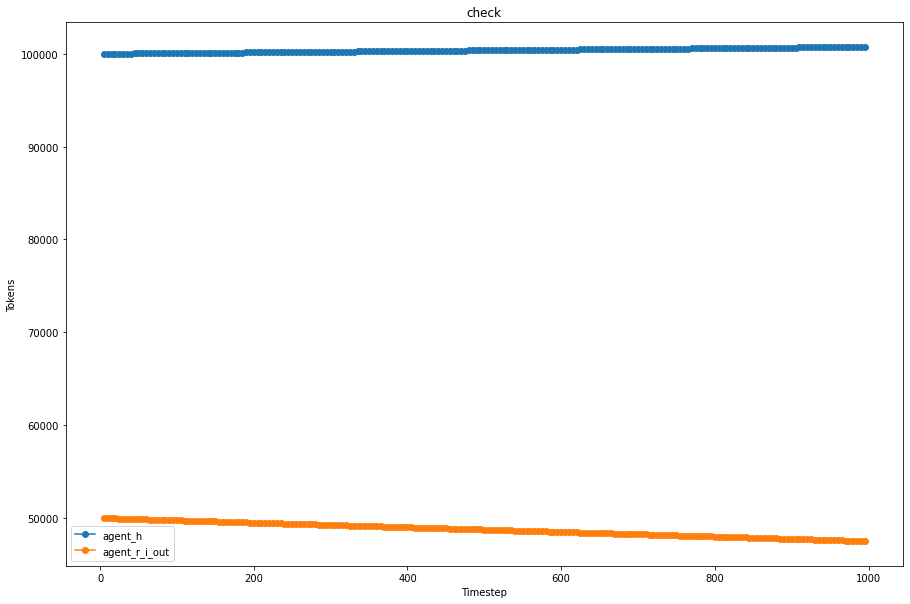

In [18]:
mean_agent_plot(rdf,'check', len(rdf['timestep']))

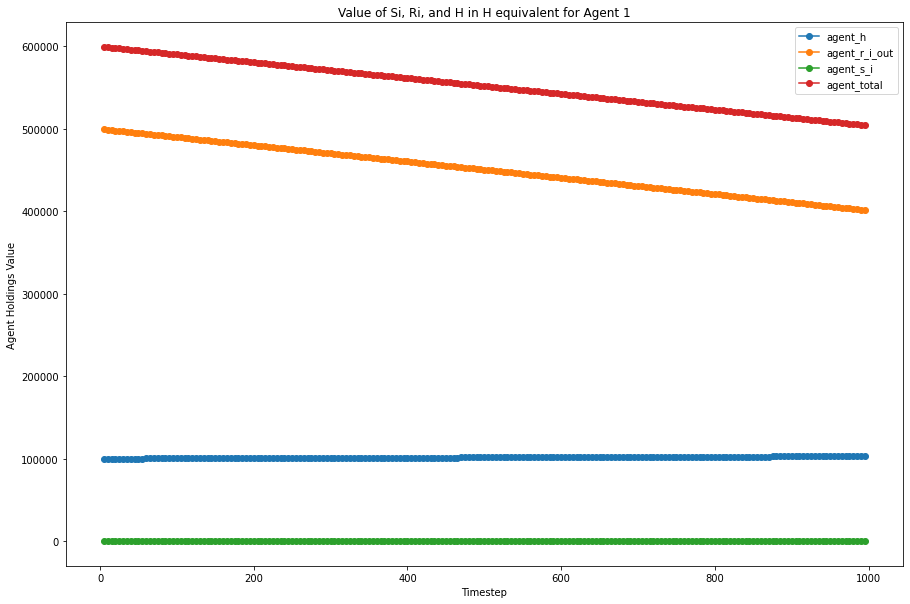

In [19]:
hydra_agent_value_plot(rdf,'Value of Si, Ri, and H in H equivalent', len(rdf['timestep']),1,'i')

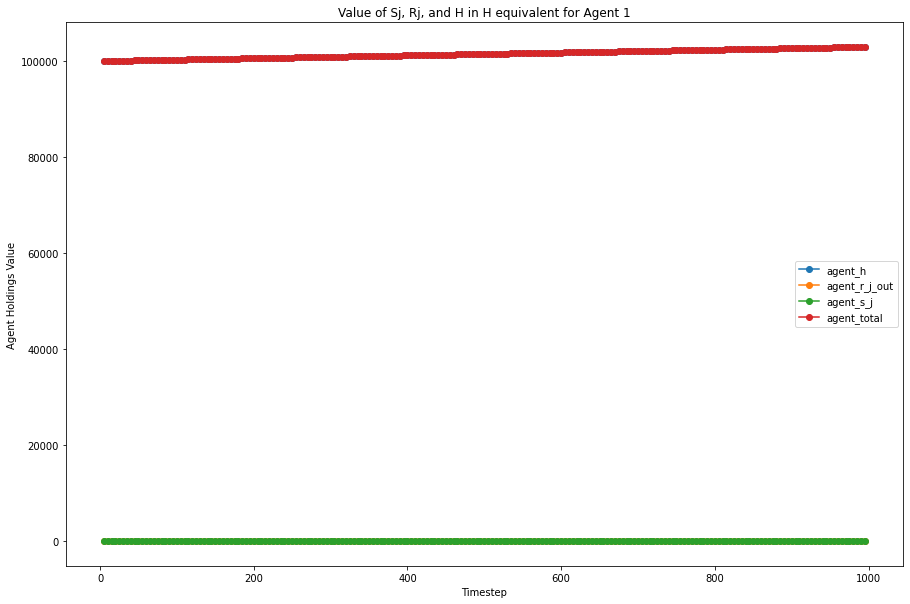

In [20]:
hydra_agent_value_plot(rdf,'Value of Sj, Rj, and H in H equivalent', len(rdf['timestep']),1,'j')

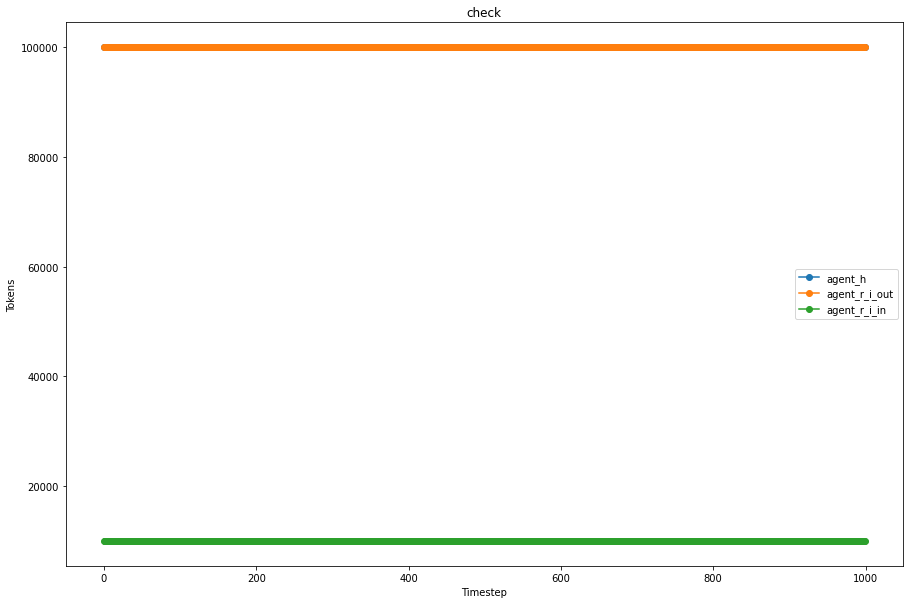

In [21]:
agent_plot(rdf,'check', len(rdf['timestep']),3,'i')

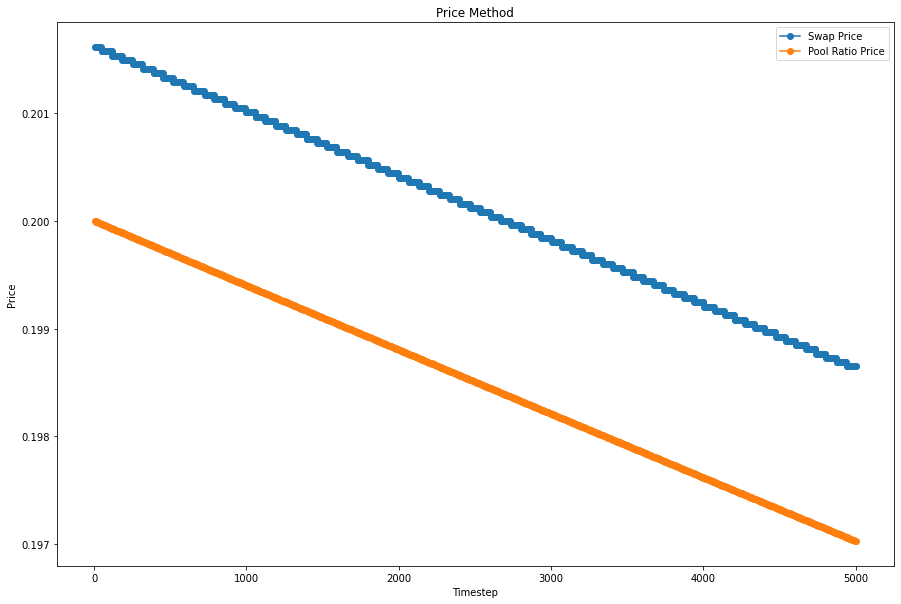

In [22]:
price_plot(rdf,'Price Method', 'UNI_P_RQi', 'UNI_Ri', 'UNI_Qi')

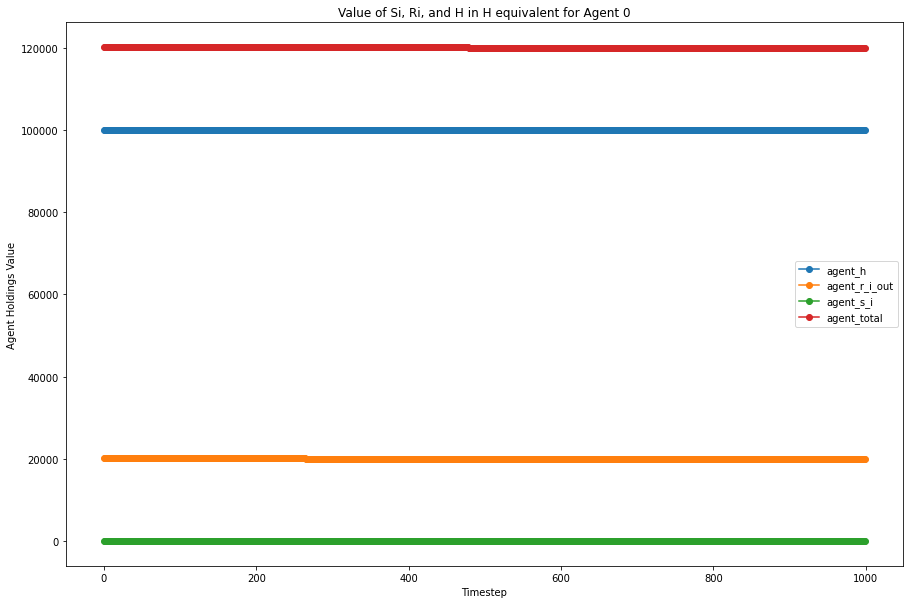

In [23]:
agent_value_plot(rdf,'Value of Si, Ri, and H in H equivalent', len(rdf['timestep']),0, 'i')

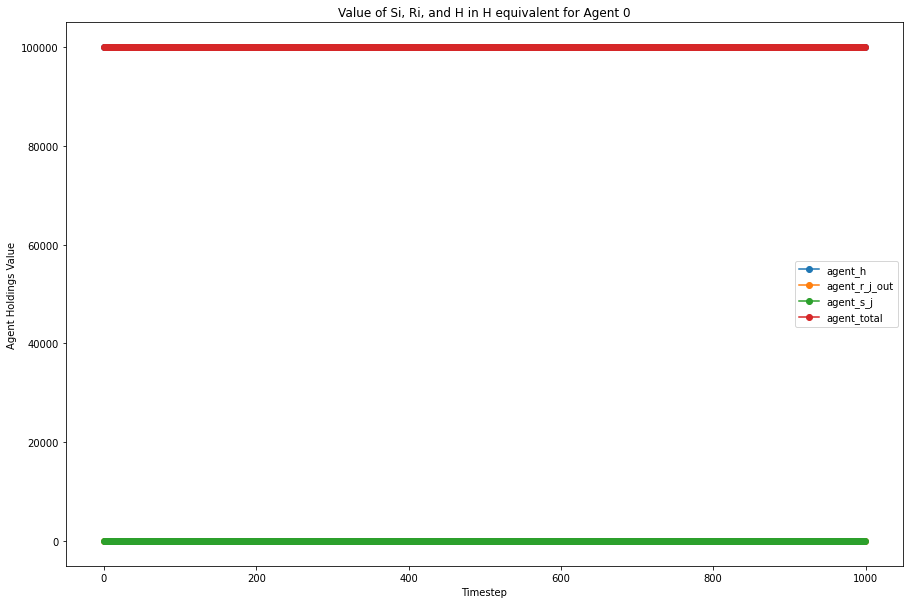

In [24]:
agent_value_plot(rdf,'Value of Si, Ri, and H in H equivalent', len(rdf['timestep']),0, 'j')

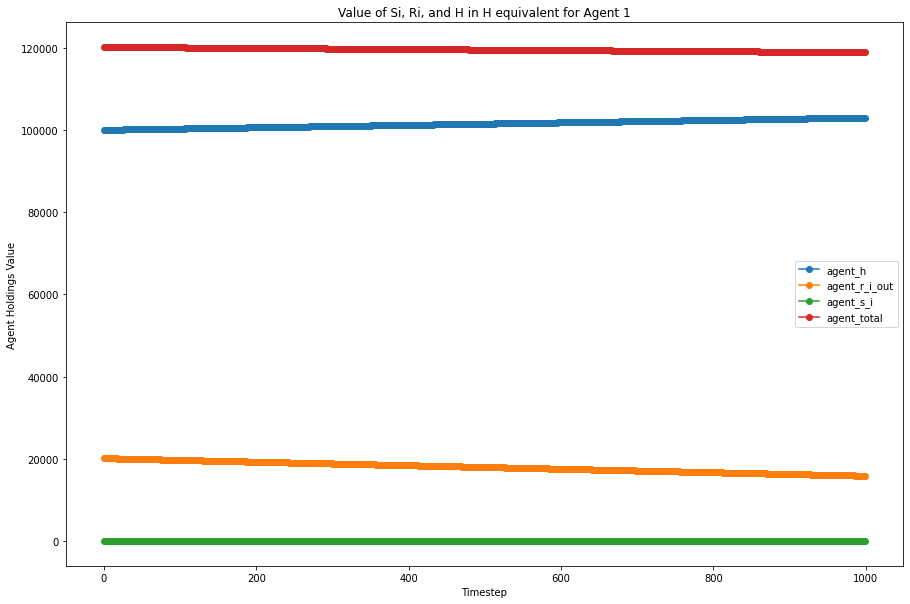

In [25]:
agent_value_plot(rdf,'Value of Si, Ri, and H in H equivalent', len(rdf['timestep']),1,'i')

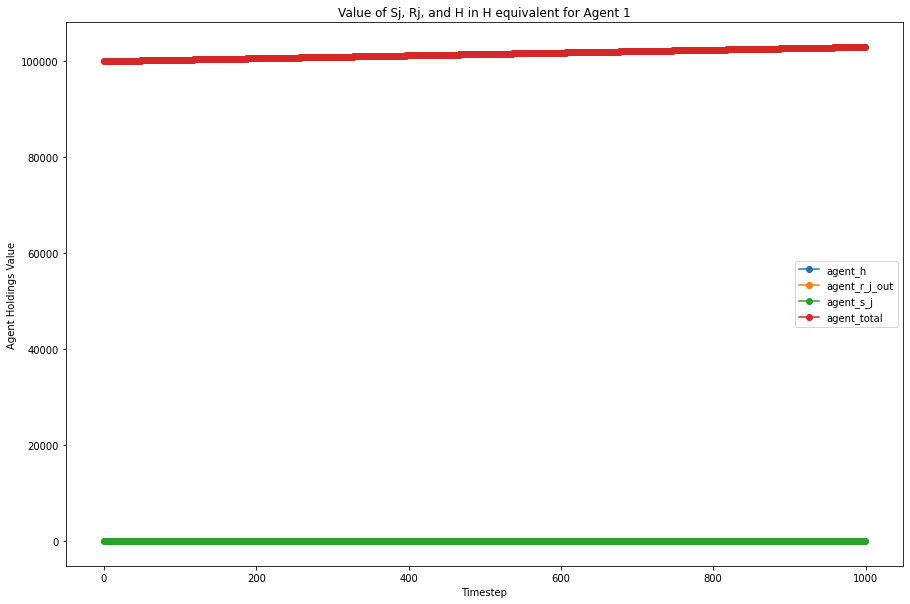

In [26]:
agent_value_plot(rdf,'Value of Sj, Rj, and H in H equivalent', len(rdf['timestep']),1,'j')

In [27]:
print(rdf.pool[10])

<class 'model.parts.asset_utils.Asset'>: {'pool': {'i': {'R': 1000020, 'S': 200000000000, 'W': 200000000000, 'P': 0.19999400614972668}, 'j': {'R': 1000000, 'S': 200000000000, 'W': 200000000000, 'P': 0.19999800602984963}}}


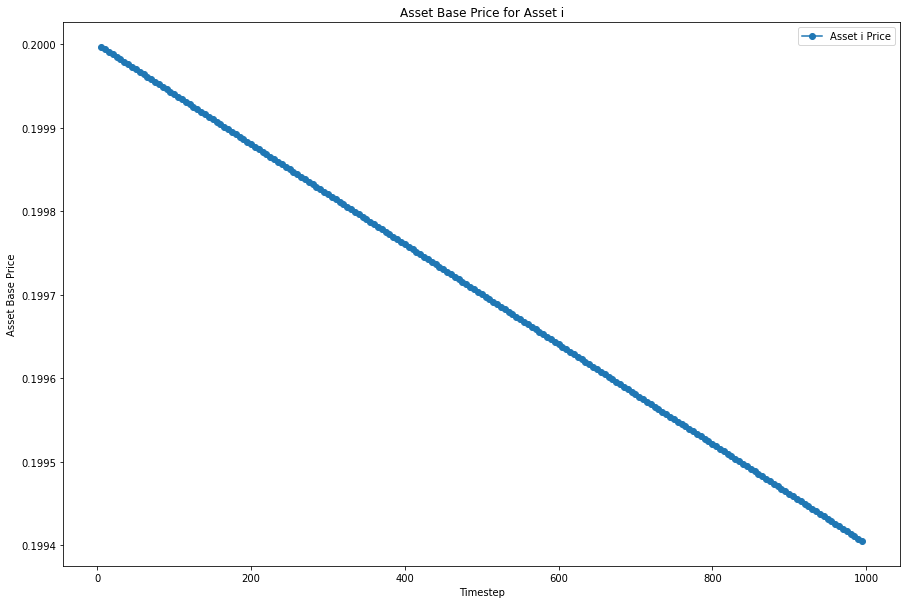

In [28]:
hydra_pool_price_plot(rdf,'Asset Base Price', len(rdf['timestep']),'i')

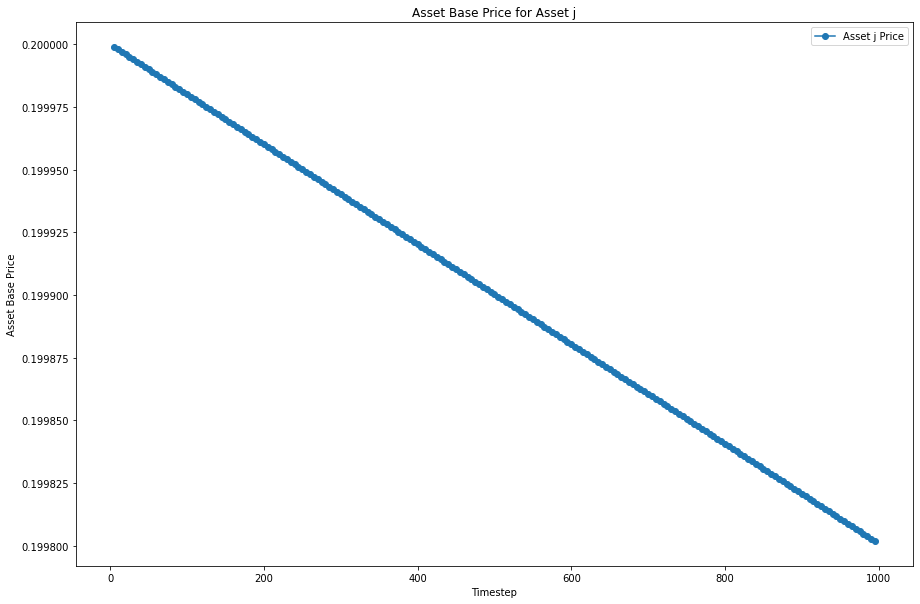

In [29]:
hydra_pool_price_plot(rdf,'Asset Base Price', len(rdf['timestep']),'j')